In [1]:

import ast

import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Crippen
from rdkit.Chem.Draw import MolsToGridImage
import matplotlib.pyplot as plt
import pandas as pd


import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType
from rdkit.Chem.Draw import MolsToGridImage

# Load all the datasets to create the model 

In [2]:
#Load teh three datasets

d1 = pd.read_csv('C:\\Users\\Rebe\\Documents\\Python programms\\Capstone_code\\NLP_approach\\smile_1.csv')
d2 = pd.read_csv('C:\\Users\\Rebe\\Documents\\Python programms\\Capstone_code\\NLP_approach\\smile_2.csv')
d3 = pd.read_csv('C:\\Users\\Rebe\\Documents\\Python programms\\Capstone_code\\NLP_approach\\smile_3.csv')

#change the name of the column canonical_smiles to 'smile'
d3.rename(columns={'canonical_smiles':'smiles'}, inplace=True)

#concatenate the three datasets
frames = [d1, d2, d3]
df = pd.concat(frames)

df = df.drop_duplicates(subset=['smiles'])

df.head()


,smiles
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...


In [3]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import QED

def process_dataset(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)

    # If the column is named 'canonical_smiles', rename it to 'smiles'
    if 'canonical_smiles' in df.columns:
        df.rename(columns={'canonical_smiles': 'smiles'}, inplace=True)

    # Remove duplicates
    df = df.drop_duplicates(subset=['smiles'])

    # Define a function to calculate QED
    def calculate_qed(smiles):
        try:
            mol = Chem.MolFromSmiles(smiles)
            return QED.qed(mol)
        except:
            return None

    # Calculate QED for each molecule
    df['qed'] = df['smiles'].apply(calculate_qed)

    # Keep only 'smiles' and 'qed' columns
    df = df[['smiles', 'qed']]

    return df

# Process each dataset individually
d1_processed = process_dataset('C:\\Users\\Rebe\\Documents\\Python programms\\Capstone_code\\NLP_approach\\smile_1.csv')
d2_processed = process_dataset('C:\\Users\\Rebe\\Documents\\Python programms\\Capstone_code\\NLP_approach\\smile_2.csv')
d3_processed = process_dataset('C:\\Users\\Rebe\\Documents\\Python programms\\Capstone_code\\NLP_approach\\smile_3.csv')

# Display the first few rows of the processed datasets
print(d1_processed.head())
print(d2_processed.head())
print(d3_processed.head())


In [25]:
d1_processed.to_csv('smiles1_qed.csv', index=False)
d2_processed.to_csv('smiles2_qed.csv', index=False)
d3_processed.to_csv('smiles3_qed.csv', index=False)

In [2]:
d1 = pd.read_csv('smiles1_qed.csv')
d2 = pd.read_csv('smiles2_qed.csv')
d3 = pd.read_csv('smiles3_qed.csv')

frames = [d1, d2, d3]
df = pd.concat(frames)

df = df.drop_duplicates(subset=['smiles'])

df.head()

,smiles,qed
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,0.731901
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,0.941112
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,0.626105
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,0.716225
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,0.809572


In [3]:
df = d1

len(d3)


52

In [4]:
SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", "P", "Cl", "Br"]'

bond_mapping = {"SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2, "AROMATIC": 3}
bond_mapping.update(
    {0: BondType.SINGLE, 1: BondType.DOUBLE, 2: BondType.TRIPLE, 3: BondType.AROMATIC}
)
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)

MAX_MOLSIZE = max(df["smiles"].str.len())
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

BATCH_SIZE = 100
EPOCHS = 100

VAE_LR = 5e-4
NUM_ATOMS = 120  # Maximum number of atoms

ATOM_DIM = len(SMILE_CHARSET)  # Number of atom types
BOND_DIM = 4 + 1  # Number of bond types
LATENT_DIM = 435  # Size of the latent space



In [5]:

def smiles_to_graph(smiles):
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features


def graph_to_molecule(graph):
    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule; for more information on sanitization, see
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Let's be strict. If sanitization fails, return None
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule

# Dataset generation for training the model

In [6]:
data = d1
data.dropna(inplace=True)

In [7]:


train_df = data.sample(frac=0.75, random_state=42)
val_df = data.drop(train_df.index)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
train_df = data.sample(frac=0.75, random_state=42)  # random state is a seed value
train_df.reset_index(drop=True, inplace=True)

adjacency_tensor, feature_tensor, qed_tensor = [], [], []
for idx in range(38):
    adjacency, features = smiles_to_graph(train_df.loc[idx]["smiles"])
    qed = train_df.loc[idx]["qed"]
    adjacency_tensor.append(adjacency)
    feature_tensor.append(features)
    qed_tensor.append(qed)

adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)
qed_tensor = np.array(qed_tensor)


class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Apply linear transformation
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = tf.reduce_sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)

In [8]:
val_adjacency, val_features, val_qed = [], [], []
for idx in range(12):
    v_adjacency, v_features = smiles_to_graph(val_df.loc[idx]["smiles"])
    v_qed = val_df.loc[idx]["qed"]
    val_adjacency.append(v_adjacency)
    val_features.append(v_features)
    val_qed.append(v_qed)

val_adjacency = np.array(val_adjacency)
val_features = np.array(val_features)
val_qed = np.array(val_qed)

In [9]:
def get_encoder(
    gconv_units, latent_dim, adjacency_shape, feature_shape, dense_units, dropout_rate
):
    adjacency = keras.layers.Input(shape=adjacency_shape)
    features = keras.layers.Input(shape=feature_shape)

    # Propagate through one or more graph convolutional layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )
    # Reduce 2-D representation of molecule to 1-D
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)

    # Propagate through one or more densely connected layers
    for units in dense_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)

    z_mean = layers.Dense(latent_dim, dtype="float32", name="z_mean")(x)
    log_var = layers.Dense(latent_dim, dtype="float32", name="log_var")(x)

    encoder = keras.Model([adjacency, features], [z_mean, log_var], name="encoder")

    return encoder


def get_decoder(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):
    latent_inputs = keras.Input(shape=(latent_dim,))

    x = latent_inputs
    for units in dense_units:
        x = keras.layers.Dense(units, activation="tanh")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # Map outputs of previous layer (x) to [continuous] adjacency tensors (x_adjacency)
    x_adjacency = keras.layers.Dense(tf.math.reduce_prod(adjacency_shape))(x)
    x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)
    # Symmetrify tensors in the last two dimensions
    x_adjacency = (x_adjacency + tf.transpose(x_adjacency, (0, 1, 3, 2))) / 2
    x_adjacency = keras.layers.Softmax(axis=1)(x_adjacency)

    # Map outputs of previous layer (x) to [continuous] feature tensors (x_features)
    x_features = keras.layers.Dense(tf.math.reduce_prod(feature_shape))(x)
    x_features = keras.layers.Reshape(feature_shape)(x_features)
    x_features = keras.layers.Softmax(axis=2)(x_features)

    decoder = keras.Model(
        latent_inputs, outputs=[x_adjacency, x_features], name="decoder"
    )

    return decoder

In [10]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_log_var)[0]
        dim = tf.shape(z_log_var)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
train_losses = []
val_losses = []

In [12]:
class MoleculeGenerator(keras.Model):
    def __init__(self, encoder, decoder, max_len, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.property_prediction_layer = layers.Dense(1)
        self.max_len = max_len

        self.train_total_loss_tracker = keras.metrics.Mean(name="train_total_loss")
        self.val_total_loss_tracker = keras.metrics.Mean(name="val_total_loss")

    def get_config(self):
        # Implement get_config method to serialize your custom model
        config = super().get_config()
        config.update({"encoder": self.encoder, "decoder": self.decoder, "max_len": self.max_len})
        return config

    def train_step(self, data):
        adjacency_tensor, feature_tensor, qed_tensor = data[0]
        graph_real = [adjacency_tensor, feature_tensor]
        self.batch_size = tf.shape(qed_tensor)[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, qed_pred, gen_adjacency, gen_features = self(
                graph_real, training=True
            )
            graph_generated = [gen_adjacency, gen_features]
            total_loss = self._compute_loss(
                z_log_var, z_mean, qed_tensor, qed_pred, graph_real, graph_generated
            )

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.train_total_loss_tracker.update_state(total_loss)
        return {"loss": self.train_total_loss_tracker.result()}

    def _compute_loss(
        self, z_log_var, z_mean, qed_true, qed_pred, graph_real, graph_generated
    ):

        adjacency_real, features_real = graph_real
        adjacency_gen, features_gen = graph_generated

        adjacency_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.categorical_crossentropy(adjacency_real, adjacency_gen),
                axis=(1, 2),
            )
        )
        features_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.categorical_crossentropy(features_real, features_gen),
                axis=(1),
            )
        )
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), 1
        )
        kl_loss = tf.reduce_mean(kl_loss)

        property_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(qed_true, qed_pred)
        )

        graph_loss = self._gradient_penalty(graph_real, graph_generated)

        return kl_loss + property_loss + graph_loss + adjacency_loss + features_loss

    def _gradient_penalty(self, graph_real, graph_generated):
        # Unpack graphs
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

        # Generate interpolated graphs (adjacency_interp and features_interp)
        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated

        # Compute the logits of interpolated graphs
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            _, _, logits, _, _ = self(
                [adjacency_interp, features_interp], training=True
            )

        # Compute the gradients with respect to the interpolated graphs
        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        # Compute the gradient penalty
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
        return tf.reduce_mean(
            tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1))
            + tf.reduce_mean(grads_features_penalty, axis=(-1))
        )

    def inference(self, batch_size):
        z = tf.random.normal((batch_size, LATENT_DIM))
        reconstruction_adjacency, reconstruction_features = model.decoder.predict(z)
        # obtain one-hot encoded adjacency tensor
        adjacency = tf.argmax(reconstruction_adjacency, axis=1)
        adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
        # Remove potential self-loops from adjacency
        adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
        # obtain one-hot encoded feature tensor
        features = tf.argmax(reconstruction_features, axis=2)
        features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
        return [
            graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
            for i in range(batch_size)
        ]

    def call(self, inputs):
        z_mean, log_var = self.encoder(inputs)
        z = Sampling()([z_mean, log_var])

        gen_adjacency, gen_features = self.decoder(z)

        property_pred = self.property_prediction_layer(z_mean)

        return z_mean, log_var, property_pred, gen_adjacency, gen_features
    
    def test_step(self, data):
        # Unpack the data
        val_adjacency, val_features, val_qed = data

        # Forward pass
        z_mean, z_log_var = self.encoder([val_adjacency, val_features])
        z = Sampling()([z_mean, z_log_var])
        gen_adjacency, gen_features = self.decoder(z)
        qed_pred = self.property_prediction_layer(z_mean)

        # Compute the loss
        t_val_loss = self._compute_loss(z_log_var, z_mean, val_qed, qed_pred, 
                                    [val_adjacency, val_features], 
                                    [gen_adjacency, gen_features])

        # Update the validation loss tracker
        self.val_total_loss_tracker.update_state(t_val_loss)

        # Return the validation loss
        return {"val_loss": self.val_total_loss_tracker.result()}

In [13]:
vae_optimizer = tf.keras.optimizers.Adam(learning_rate=VAE_LR)

encoder = get_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[512],
    dropout_rate=0.0,
)
decoder = get_decoder(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)

In [14]:
model = MoleculeGenerator(encoder, decoder, MAX_MOLSIZE)


In [ ]:
'''
vae_optimizer = tf.keras.optimizers.Adam(1e-5)

encoder = get_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[512],
    dropout_rate=0.0,
)
decoder = get_decoder(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)
'''

In [15]:
model.compile(vae_optimizer)
history = model.fit([adjacency_tensor, feature_tensor, qed_tensor], epochs=EPOCHS)

Epoch 1/100
2/2 [==============================] - 7s 674ms/step - loss: 70119.3281
Epoch 2/100
2/2 [==============================] - 1s 552ms/step - loss: 69685.0130
Epoch 3/100
2/2 [==============================] - 1s 557ms/step - loss: 69439.3672
Epoch 4/100
2/2 [==============================] - 1s 580ms/step - loss: 69290.7057
Epoch 5/100
2/2 [==============================] - 1s 608ms/step - loss: 69201.4062
Epoch 6/100
2/2 [==============================] - 1s 577ms/step - loss: 69123.1797
Epoch 7/100
2/2 [==============================] - 1s 665ms/step - loss: 69061.7188
Epoch 8/100
2/2 [==============================] - 2s 723ms/step - loss: 69012.4531
Epoch 9/100
2/2 [==============================] - 2s 651ms/step - loss: 68981.0911
Epoch 10/100
2/2 [==============================] - 1s 575ms/step - loss: 68959.0052
Epoch 11/100
2/2 [==============================] - 1s 618ms/step - loss: 68938.0547
Epoch 12/100
2/2 [==============================] - 2s 698ms/step - loss: 

In [63]:
#model.save_weights('test_1')


TypeError: this __dict__ descriptor does not support '_DictWrapper' objects

C:\Users\Rebe\AppData\Local\Temp\ipykernel_18244\950291653.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss_values, 'bo-', label='Training loss', color = 'purple')


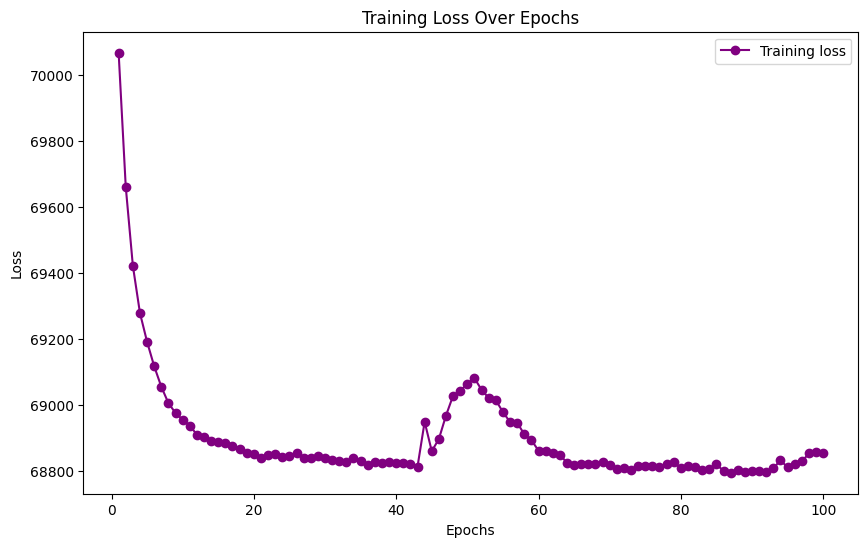

In [17]:
loss_values = history.history['loss']
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, 'bo-', label='Training loss', color = 'purple')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
molecules = model.inference(2000)

MolsToGridImage(
    [m for m in molecules if m is not None][:1000], molsPerRow=5, subImgSize=(260, 160)
)

63/63 [==============================] - 5s 75ms/step


[13:06:21] Explicit valence for atom # 1 C, 7, is greater than permitted
[13:06:22] Explicit valence for atom # 0 B, 117, is greater than permitted
[13:06:22] Explicit valence for atom # 1 C, 5, is greater than permitted
[13:06:22] Explicit valence for atom # 0 B, 117, is greater than permitted
[13:06:22] Explicit valence for atom # 1 C, 7, is greater than permitted
[13:06:22] non-ring atom 2 marked aromatic
[13:06:22] Explicit valence for atom # 1 C, 7, is greater than permitted
[13:06:22] Explicit valence for atom # 1 C, 7, is greater than permitted
[13:06:22] Explicit valence for atom # 0 S, 115, is greater than permitted
[13:06:22] Explicit valence for atom # 1 C, 7, is greater than permitted
[13:06:22] Explicit valence for atom # 10 C, 6, is greater than permitted
[13:06:22] Explicit valence for atom # 0 B, 118, is greater than permitted
[13:06:22] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:06:22] Explicit valence for atom # 1 C, 7, is greater than permitted

RuntimeError: Pre-condition Violation
	no draw context
	Violation occurred on line 214 in file Code\GraphMol\MolDraw2D\MolDraw2DCairo.cpp
	Failed Expression: dp_cr
	RDKIT: 2022.09.5
	BOOST: 1_78


In [27]:
test1= MoleculeGenerator(encoder, decoder, MAX_MOLSIZE)
test1.compile(vae_optimizer)


In [28]:
test1.load_weights('vae1.h5')

ValueError: Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. Call the Model first, then load the weights.

In [ ]:

molecules = test1.inference(1000)

MolsToGridImage(
    [m for m in molecules if m is not None][:1000], molsPerRow=5, subImgSize=(260, 160)
)

1/1 [==============================] - 0s 234ms/step


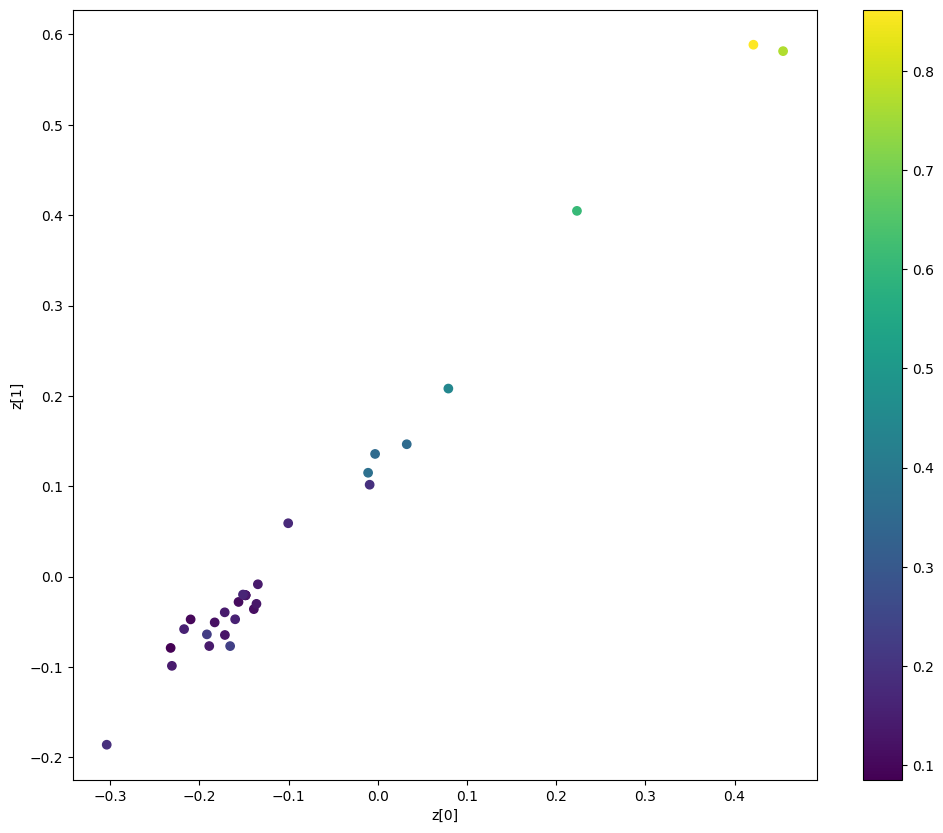

In [82]:
def plot_latent(vae, data, labels):
    # display a 2D plot of the property in the latent space
    z_mean, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


plot_latent(model, [adjacency_tensor[:8000], feature_tensor[:8000]], qed_tensor[:8000])